In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import random
from os import listdir

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.preprocessing import  LabelBinarizer

import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
#from keras.preprocessing.image import img_to_array, array_to_img
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import callbacks

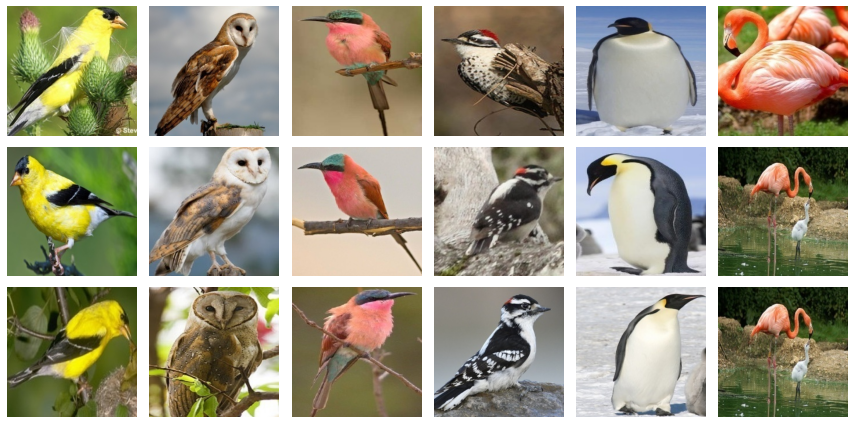

In [3]:
plt.figure(figsize=(12,6))
path = "Bird Species Dataset"
i = 1
# for i, directory in enumerate(listdir(path)):
for directory in listdir(path):
    count = 0
    j = i
    for files in listdir(f"{path}/{directory}"):
        count += 1
        plt.subplot(3, 6, j)
        j += 6
        img = path +'/'+ directory + '/' + random.choice(sorted(listdir(f"{path}/{directory}")))
        randImg = cv.imread(img)
        randImg = cv.cvtColor(randImg, cv.COLOR_BGR2RGB)
        plt.imshow(randImg)
        plt.axis("off")
        if count == 3:
            i += 1
            break
plt.tight_layout()
plt.show()

In [4]:
dataPath = "Bird Species Dataset"
direc = dataPath
rootDir = listdir(direc)
imageList, labelList = [], []
rootDir

['AMERICAN GOLDFINCH',
 'BARN OWL',
 'CARMINE BEE-EATER',
 'DOWNY WOODPECKER',
 'EMPEROR PENGUIN',
 'FLAMINGO']

In [5]:
# Reading and converting image to numpy array
for directory in rootDir:
    count = 0
    for files in listdir(f"{direc}/{directory}"):
        count += 1
        image_path = f"{direc}/{directory}/{files}"
        image = cv.imread(image_path)
        # image = cv.resize(image, (224, 224)) # can be used instead of reshape but can ruin the image when resized
        image = keras.preprocessing.image.img_to_array(image)
        imageList.append(image)
        labelList.append(directory)
    print(directory, ":", count) # number of images in each class
    
# print(imageList[0], labelList[0])

AMERICAN GOLDFINCH : 143
BARN OWL : 129
CARMINE BEE-EATER : 131
DOWNY WOODPECKER : 137
EMPEROR PENGUIN : 139
FLAMINGO : 132


In [6]:
# Another way to find the number of images in each class
labelCounts = pd.DataFrame(labelList).value_counts()
labelCounts

AMERICAN GOLDFINCH    143
EMPEROR PENGUIN       139
DOWNY WOODPECKER      137
FLAMINGO              132
CARMINE BEE-EATER     131
BARN OWL              129
dtype: int64

In [7]:
len(labelList)
labelList = np.array(labelList)
labelList.shape

(811,)

In [8]:
xTrain, xTest, yTrain, yTest = train_test_split(imageList, labelList, test_size=0.3, random_state = 0) 
print(f"Number of Training dataset: {len(xTrain)}\nNumber of Testing dataset: {len(xTest)}")

Number of Training dataset: 567
Number of Testing dataset: 244


In [9]:
# Normalize and reshape data
xTrain = np.array(xTrain, dtype=np.float16) / 225.0
xTest = np.array(xTest, dtype=np.float16) / 225.0
xTrain = xTrain.reshape(-1, 224, 224, 3) # instead of cv.resize
xTest = xTest.reshape(-1, 224, 224, 3) # the number of images, the height of each image, the width of each image, number of channels.

In [10]:
xTrain[0].shape

(224, 224, 3)

In [11]:
# Label binarizing to one hot encode the target variables
lb = LabelBinarizer()
yTrain = lb.fit_transform(yTrain)
yTest = lb.fit_transform(yTest)
print(lb.classes_)
yTest.shape

['AMERICAN GOLDFINCH' 'BARN OWL' 'CARMINE BEE-EATER' 'DOWNY WOODPECKER'
 'EMPEROR PENGUIN' 'FLAMINGO']


(244, 6)

In [17]:
def modelANN(): 
    model = Sequential([
        Flatten(input_shape=(224,224,3)),
        Dense(512, activation ='relu'),
        Dense(256, activation ='relu'),
        Dense(128, activation ='relu'),
        Dense(6, activation='softmax'),
    ])
    model.compile(
        optimizer= Adam(learning_rate=0.005),
        loss='categorical_crossentropy',
        metrics=['acc']
    )
    return model

In [18]:
def modelCNN():
    model = keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(6, activation='softmax') 
    ])
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    model.summary()
    return model

In [19]:
early_stopping = callbacks.EarlyStopping(
        patience=10,
        min_delta=0,
        monitor='val_loss',
        restore_best_weights=True,
        verbose=0,
        mode='min', 
        baseline=None,
    )
plateau = callbacks.ReduceLROnPlateau(
            monitor='val_loss', 
            factor=0.2, 
            patience=4, 
            verbose=0,
            mode='min')
CNN_model_checkpoint = callbacks.ModelCheckpoint('CNN_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)
ANN_model_checkpoint = callbacks.ModelCheckpoint('ANN_best_model.h5', monitor='val_loss', mode='min', patience = 10 ,save_best_only=True)

In [38]:
ANN = modelANN()
historyANN = ANN.fit(xTrain , yTrain,
                validation_data = (xTest , yTest),
                epochs = 23,
                callbacks = [early_stopping , plateau, ANN_model_checkpoint],
              )

Epoch 1/23
18/18 [==============================] - 11s 556ms/step - loss: 455.9929 - acc: 0.1587 - val_loss: 63.4179 - val_acc: 0.1967 - lr: 0.0050
Epoch 2/23
18/18 [==============================] - 10s 557ms/step - loss: 50.1351 - acc: 0.1658 - val_loss: 27.4625 - val_acc: 0.2131 - lr: 0.0050
Epoch 3/23
18/18 [==============================] - 10s 557ms/step - loss: 9.5140 - acc: 0.2504 - val_loss: 3.6456 - val_acc: 0.3484 - lr: 0.0050
Epoch 4/23
18/18 [==============================] - 10s 560ms/step - loss: 2.7948 - acc: 0.3704 - val_loss: 1.9413 - val_acc: 0.3607 - lr: 0.0050
Epoch 5/23
18/18 [==============================] - 10s 556ms/step - loss: 1.7089 - acc: 0.4374 - val_loss: 1.4746 - val_acc: 0.4221 - lr: 0.0050
Epoch 6/23
18/18 [==============================] - 10s 555ms/step - loss: 1.0583 - acc: 0.6173 - val_loss: 1.2012 - val_acc: 0.5615 - lr: 0.0050
Epoch 7/23
18/18 [==============================] - 19s 1s/step - loss: 0.8527 - acc: 0.6861 - val_loss: 0.9583 - val_a

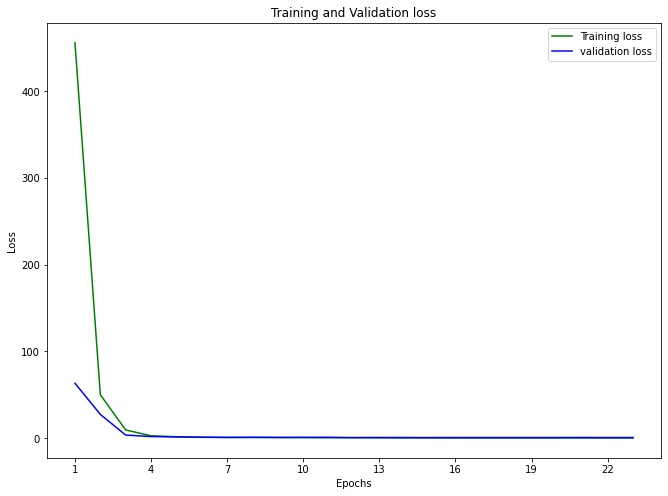

In [41]:
plt.figure(figsize=(11,8))
trainLoss = historyANN.history['loss']
valLoss = historyANN.history['val_loss']
epochs = range(1,24)
plt.plot(epochs, trainLoss, 'g', label='Training loss')
plt.plot(epochs, valLoss, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1,24,3))
plt.legend()
plt.show()

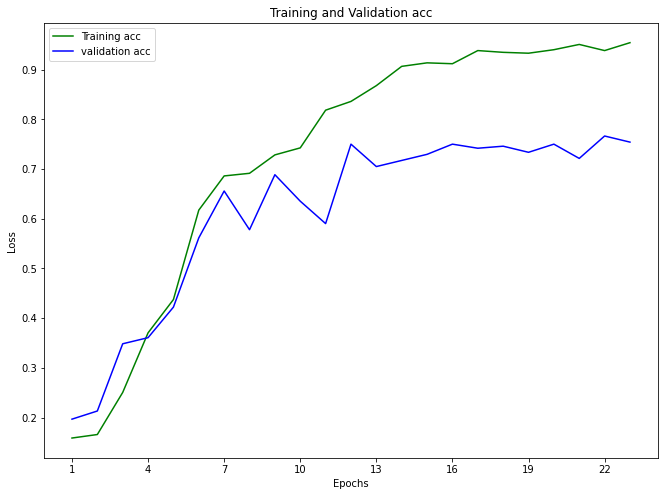

In [42]:
plt.figure(figsize=(11,8))
trainLoss = historyANN.history['acc']
valLoss = historyANN.history['val_acc']
epochs = range(1,24)
plt.plot(epochs, trainLoss, 'g', label='Training acc')
plt.plot(epochs, valLoss, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1,24,3))
plt.legend()
plt.show()

In [61]:
y_pred = ANN.predict(xTest)
y_predicted_labels = [np.argmax(i) for i in y_pred]
y_predicted_labels = np.array(y_predicted_labels)
y_predicted_labels.shape
y_predicted_labels

8/8 [==============================] - 0s 39ms/step


array([4, 1, 5, 1, 0, 0, 3, 3, 1, 5, 4, 3, 0, 1, 2, 1, 3, 0, 0, 1, 2, 3,
       0, 3, 4, 1, 4, 5, 0, 5, 1, 0, 1, 2, 1, 2, 1, 5, 2, 4, 2, 3, 1, 3,
       4, 5, 4, 4, 0, 1, 3, 1, 2, 1, 5, 1, 2, 4, 3, 1, 4, 1, 5, 4, 5, 5,
       1, 1, 1, 5, 1, 3, 5, 5, 2, 5, 5, 3, 3, 0, 0, 5, 1, 2, 0, 4, 0, 1,
       5, 5, 4, 1, 2, 3, 4, 2, 2, 5, 5, 2, 4, 3, 5, 3, 3, 2, 1, 3, 1, 3,
       4, 4, 3, 4, 4, 1, 0, 2, 1, 0, 5, 3, 2, 1, 2, 4, 0, 1, 5, 3, 0, 5,
       3, 2, 2, 0, 1, 1, 4, 4, 4, 2, 5, 0, 5, 1, 5, 4, 4, 5, 3, 1, 3, 5,
       3, 5, 2, 5, 0, 0, 1, 5, 0, 0, 1, 0, 2, 4, 2, 5, 2, 2, 0, 0, 4, 0,
       3, 4, 1, 3, 5, 1, 0, 2, 4, 5, 2, 5, 1, 1, 3, 1, 2, 3, 3, 4, 4, 2,
       1, 5, 5, 2, 3, 1, 4, 5, 4, 4, 3, 5, 0, 4, 3, 4, 4, 2, 2, 2, 5, 5,
       5, 2, 3, 1, 1, 5, 1, 2, 5, 2, 0, 0, 5, 5, 2, 0, 2, 1, 4, 0, 2, 3,
       3, 1], dtype=int64)

In [62]:
y_predicted_labels = y_predicted_labels.astype(np.int32)
y_test_single = np.argmax(yTest, axis=1)
cm = confusion_matrix(y_test_single, y_predicted_labels)
print(cm)

[[33  3  3  0  1  2]
 [ 0 31  1  2  0  6]
 [ 0  1 28  0  0  6]
 [ 0  9  4 30  4  1]
 [ 0  0  1  5 32  2]
 [ 0  5  3  0  1 30]]


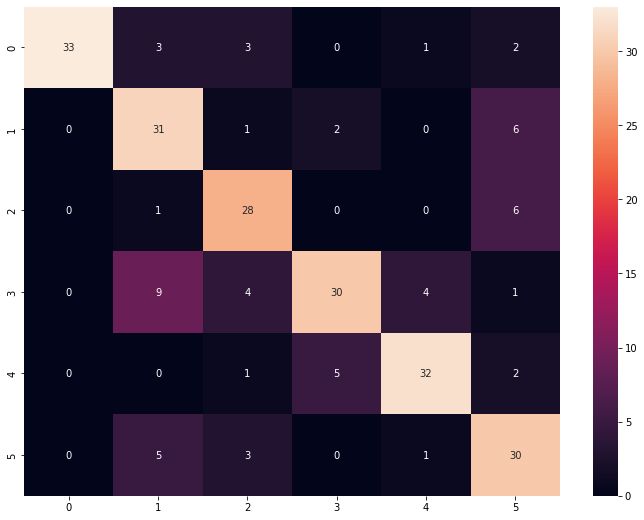

In [63]:
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [45]:
accuracy = np.mean(y_predicted_labels == y_test_single)
print("Accuracy:", accuracy)

Accuracy: 0.7540983606557377


In [46]:
print(classification_report(y_test_single, y_predicted_labels))

              precision    recall  f1-score   support

           0       1.00      0.79      0.88        42
           1       0.63      0.78      0.70        40
           2       0.70      0.80      0.75        35
           3       0.81      0.62      0.71        48
           4       0.84      0.80      0.82        40
           5       0.64      0.77      0.70        39

    accuracy                           0.75       244
   macro avg       0.77      0.76      0.76       244
weighted avg       0.78      0.75      0.76       244



In [47]:
CNN = modelCNN()
history = CNN.fit(xTrain , yTrain,
                validation_data = (xTest , yTest),
                epochs = 10,
                callbacks = [early_stopping , plateau, CNN_model_checkpoint],
              )

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

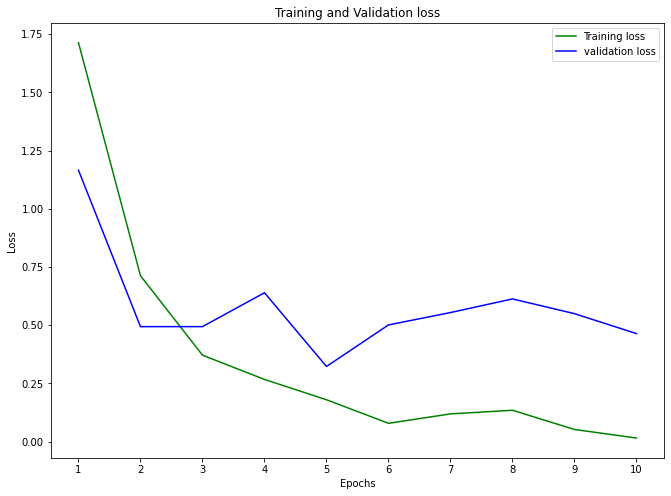

In [48]:
plt.figure(figsize=(11,8))
trainLossCNN = history.history['loss']
valLossCNN = history.history['val_loss']
epochs = range(1,11)
plt.plot(epochs, trainLossCNN, 'g', label='Training loss')
plt.plot(epochs, valLossCNN, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.xticks(np.arange(1,11))
plt.legend()
plt.show()

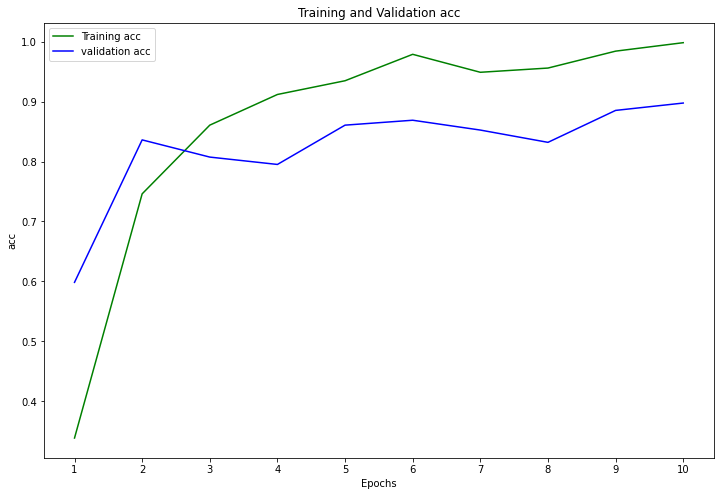

In [50]:
#Plot the Accuarcy history
plt.figure(figsize=(12,8))
trainLossCNN = history.history['accuracy']
valLossCNN = history.history['val_accuracy']
epochs = range(1,11)
plt.plot(epochs, trainLossCNN, 'g', label='Training acc')
plt.plot(epochs, valLossCNN, 'b', label='validation acc')
plt.title('Training and Validation acc')
plt.xlabel('Epochs')
plt.ylabel('acc')
plt.xticks(np.arange(1,11))
plt.legend()
plt.show()

In [64]:
y_pred = CNN.predict(xTest)
y_predicted_labels = [np.argmax(i) for i in y_pred]
y_predicted_labels = np.array(y_predicted_labels)
y_predicted_labels.shape
y_predicted_labels

8/8 [==============================] - 2s 216ms/step


array([4, 1, 0, 3, 0, 0, 3, 3, 0, 5, 4, 3, 0, 1, 5, 5, 3, 0, 0, 1, 2, 3,
       0, 1, 4, 5, 4, 5, 0, 1, 1, 0, 1, 2, 3, 5, 1, 5, 2, 4, 5, 4, 0, 3,
       4, 5, 4, 4, 0, 1, 3, 1, 2, 3, 5, 1, 2, 4, 4, 3, 4, 1, 2, 3, 3, 5,
       1, 1, 1, 5, 1, 3, 5, 5, 2, 1, 5, 3, 3, 0, 0, 5, 0, 2, 0, 4, 0, 1,
       5, 1, 4, 1, 3, 1, 3, 2, 3, 4, 5, 2, 4, 3, 2, 0, 3, 2, 5, 3, 3, 3,
       4, 4, 3, 4, 4, 3, 0, 2, 1, 0, 5, 3, 2, 1, 2, 4, 0, 1, 2, 3, 0, 2,
       3, 0, 3, 0, 1, 1, 4, 4, 4, 2, 1, 0, 5, 1, 5, 4, 4, 5, 3, 1, 3, 5,
       3, 1, 3, 5, 0, 0, 3, 1, 0, 0, 5, 0, 2, 4, 1, 1, 2, 2, 0, 0, 4, 0,
       3, 4, 5, 3, 5, 1, 0, 2, 3, 5, 1, 0, 1, 1, 3, 1, 2, 1, 3, 0, 4, 2,
       1, 5, 5, 3, 3, 3, 4, 5, 4, 4, 3, 5, 0, 4, 3, 4, 4, 2, 2, 2, 2, 5,
       5, 2, 3, 1, 1, 5, 1, 0, 5, 2, 0, 0, 5, 2, 2, 0, 1, 2, 4, 0, 2, 3,
       3, 1], dtype=int64)

In [52]:
print("Shape of yTest:", y_test_single.shape)
print("Shape of y_predicted_labels_single:", y_predicted_labels.shape)

Shape of yTest: (244,)
Shape of y_predicted_labels_single: (244,)


In [53]:
print("Unique values in yTest:", np.unique(y_test_single))
print("Unique values in y_predicted_labels_single:", np.unique(y_predicted_labels))

Unique values in yTest: [0 1 2 3 4 5]
Unique values in y_predicted_labels_single: [0 1 2 3 4 5]


In [65]:
y_predicted_labels = y_predicted_labels.astype(np.int32)
y_test_single = np.argmax(yTest, axis=1)
cm = confusion_matrix(y_test_single, y_predicted_labels)
print(cm)

[[40  2  0  0  0  0]
 [ 1 37  0  0  0  2]
 [ 0  1 31  0  0  3]
 [ 0  2  0 44  2  0]
 [ 1  1  0  4 34  0]
 [ 0  2  3  0  1 33]]


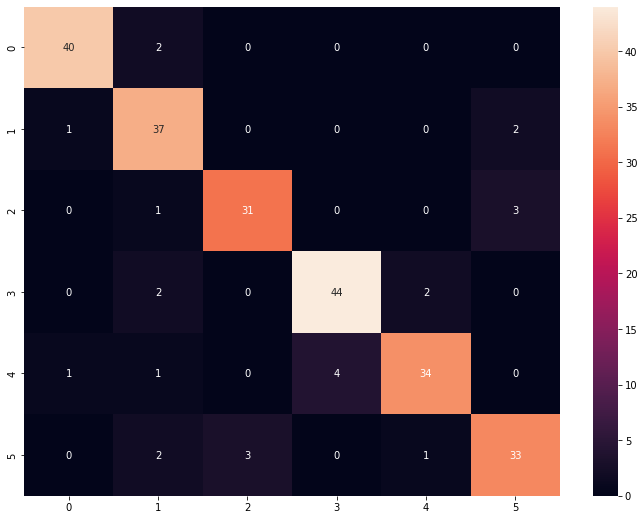

In [66]:
plt.figure(figsize=(12,9))
sns.heatmap(cm, annot=True, fmt='d')
plt.show()

In [55]:
accuracy = np.mean(y_predicted_labels == y_test_single)
print("Accuracy:", accuracy)

Accuracy: 0.8975409836065574


In [68]:
print(classification_report(y_test_single, y_predicted_labels))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        42
           1       0.82      0.93      0.87        40
           2       0.91      0.89      0.90        35
           3       0.92      0.92      0.92        48
           4       0.92      0.85      0.88        40
           5       0.87      0.85      0.86        39

    accuracy                           0.90       244
   macro avg       0.90      0.90      0.90       244
weighted avg       0.90      0.90      0.90       244



In [57]:
x_test_single = np.argmax(xTest, axis=1)
for i in range(25):
    print(f"Predicted: {y_predicted_labels[i]}, Actual: {y_test_single[i]}")

Predicted: 4, Actual: 4
Predicted: 1, Actual: 1
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 3, Actual: 3
Predicted: 3, Actual: 3
Predicted: 0, Actual: 1
Predicted: 5, Actual: 5
Predicted: 4, Actual: 4
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 5, Actual: 5
Predicted: 5, Actual: 5
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 0, Actual: 0
Predicted: 1, Actual: 1
Predicted: 2, Actual: 5
Predicted: 3, Actual: 3
Predicted: 0, Actual: 0
Predicted: 1, Actual: 3
Predicted: 4, Actual: 3
